# Examples for how to use our ecological-RL API

Our approach seeks to minimize the amount of computational information that the user
needs to provide in order to get an RL algorithm up and running on their population
dynamics control problem.

## 1. Using ray RLLib to train

The class `ray_trainer_api.ray_trainer` may be used for defining, tuning, and training an agent using the ray RLLib framework.

In [11]:
# necessary installations for our package: (uncommentthe following lines to install any needed pakages)

# ! pip install dm-tree
# ! pip install ray[rllib]
# ! pip install gymnasium
# ! pip install numpy
# ! pip install pandas
# ! pip install scipy


In [4]:
import numpy as np

from ray_trainer_api import ray_trainer
from dyn_fns import threeSp_1

### Ecological input

The cell below translates the ecological data defining the control problem to the format that our classes use.

The control problem is taken from the [rl-minicourse](https://github.com/cboettig/rl-minicourse) repository (found in the `challenge.ipynb` notebook).

The `metadata` dictionary encapsulates most of the information of the control problem, except for the actual dynamics of the system. `dyn_fn` encapsulates the dynamics of the system (note that the number of arguments of this function must match `metadata['n_sp']`).

### Metadata

In [22]:
metadata = {
	#
	# structure of ctrl problem
	'name': 'caribou_3sp', 
	'n_sp':  3,
	'n_act': 2,
	'controlled_species': [0,2],
	#
	# about episodes
	'init_pop': np.float32([0.7,0.6,1]),
	'reset_sigma': 0.05,
	'tmax': 200,
	#
	# about dynamics / control
    'extinct_thresh': 0.05,
    'penalty_fn': lambda t: - 200 / (t+1),
	'var_bound': 4,
}


# Dynamical equations

Here you can replace the `params` dictionary and the `dyn_fn` function as needed.

In [28]:
sigma = 0.1

params = {
    "r_x": np.float32(1.0),
    "r_y": np.float32(1.0),
    "K_x": np.float32(1.0),
    "K_y": np.float32(1.0),
    "beta": np.float32(0.3),
    "v0":  np.float32(0.3),
    "D": np.float32(1.1),
    "tau_yx": np.float32(0.0),
    "tau_xy": np.float32(0.0),
    "cV": np.float32(0.1),
    "f": np.float32(0.1),
    "dH": np.float32(0.1),
    "alpha": np.float32(1),
    "sigma_x": np.float32(sigma),
    "sigma_y": np.float32(sigma),
    "sigma_z": np.float32(sigma)
}

def dyn_fn(X, Y, Z):
    
    # keep these first lines: (they 'read in' the parameters)
    global params
    p = params
    
    # replace this return statement appropriately:
    #
    return np.float32([
        X + (p["r_x"] * X * (1 - (X + p["tau_xy"] * Y) / p["K_x"])
               - (1 - p["D"]) * p["beta"] * Z * (X**2) / (p["v0"]**2 + X**2)
               + p["sigma_x"] * X * np.random.normal()
               ),
        Y + (p["r_y"] * Y * (1 - (Y + p["tau_yx"]* X ) / p["K_y"] )
                - p["D"] * p["beta"] * Z * (Y**2) / (p["v0"]**2 + Y**2)
                + p["sigma_y"] * Y * np.random.normal()
                ),
        Z + p["alpha"] * p["beta"] * Z * (
                (1-p["D"]) * (X**2) / (p["v0"]**2 + X**2)
                + p["D"] * (Y**2) / (p["v0"]**2 + Y**2)
                ) - p["dH"] * Z +  p["sigma_z"] * Z  * np.random.normal()
    ])

### Utility funciton

In [29]:
def utility_fn(effort: np.ndarray, pop: np.ndarray, cost: np.ndarray = np.float32([1,1])):
    """ example  utility function, replace with actual utility.  """
    return pop[1] - sum(effort * cost)

### Training

With the previous setup, we may define our trainer and train it as shown below.

In [30]:
import ray
import os

env_config = {
				'metadata': metadata,
				'dyn_fn': dyn_fn,
				'params': params,
				'utility_fn': utility_fn,
			}

def train_workflow():
    RT = ray_trainer(
        algo_name="ppo", 
        config={
            'metadata': metadata,
            'dyn_fn': dyn_fn,
            'params': params,
            'utility_fn': utility_fn,
        },
    )
    agent = RT.train(iterations=100)
    return agent


agent = train_workflow()

2024-02-02 23:15:46,249	WARNING util.py:62 -- Install gputil for GPU system monitoring.


2024-02-02 23:15:47,532	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


### Evaluating

We visualize our agent's strategy by having it interact with our env. 

In [32]:
from base_env import ray_eco_env

env = ray_eco_env(config=env_config)

In [33]:
import pandas as pd

def generate_episode(agent, env):
    df = []
    episode_reward = 0
    observation, _ = env.reset()
    for t in range(env.env.metadata.tmax):
        action = agent.compute_single_action(observation, deterministic=True)
        pop = env.env.state_to_pop(observation) # natural units
        effort = (action + 1)/2
        df.append([t, episode_reward, 
                 *effort, 
                 *pop
                ])

        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    df = pd.DataFrame(df, columns=['t', 'reward', 'x_cull', 'y_cull', 'x', 'y', 'z'])
    
    return {'ep_df': df, 'reward': episode_reward}

In [34]:
from plotnine import ggplot, aes, geom_line

def plot_episode(df):
    """ plots an episode df. df generated using generate_episode(). """
    return ggplot(
        df.melt(["t"]),
        aes("t", "value", color="variable"),
    ) + geom_line()


145.43260389364468


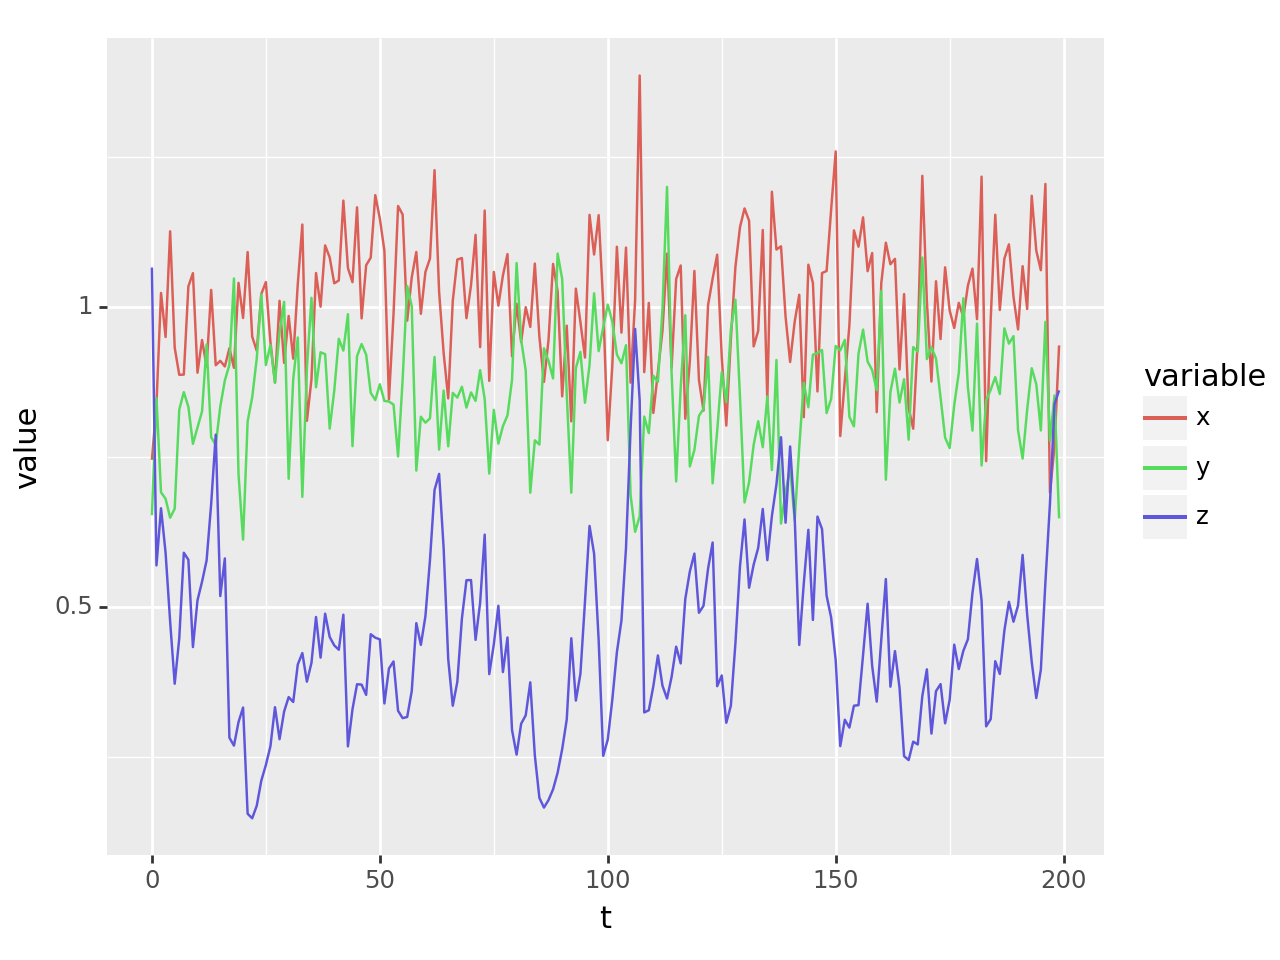

<Figure Size: (640 x 480)>

In [35]:
episode = generate_episode(agent, env)
episode_df = episode["ep_df"]
print(episode['reward'])
plot_episode(episode_df[['t', 'x', 'y', 'z']])

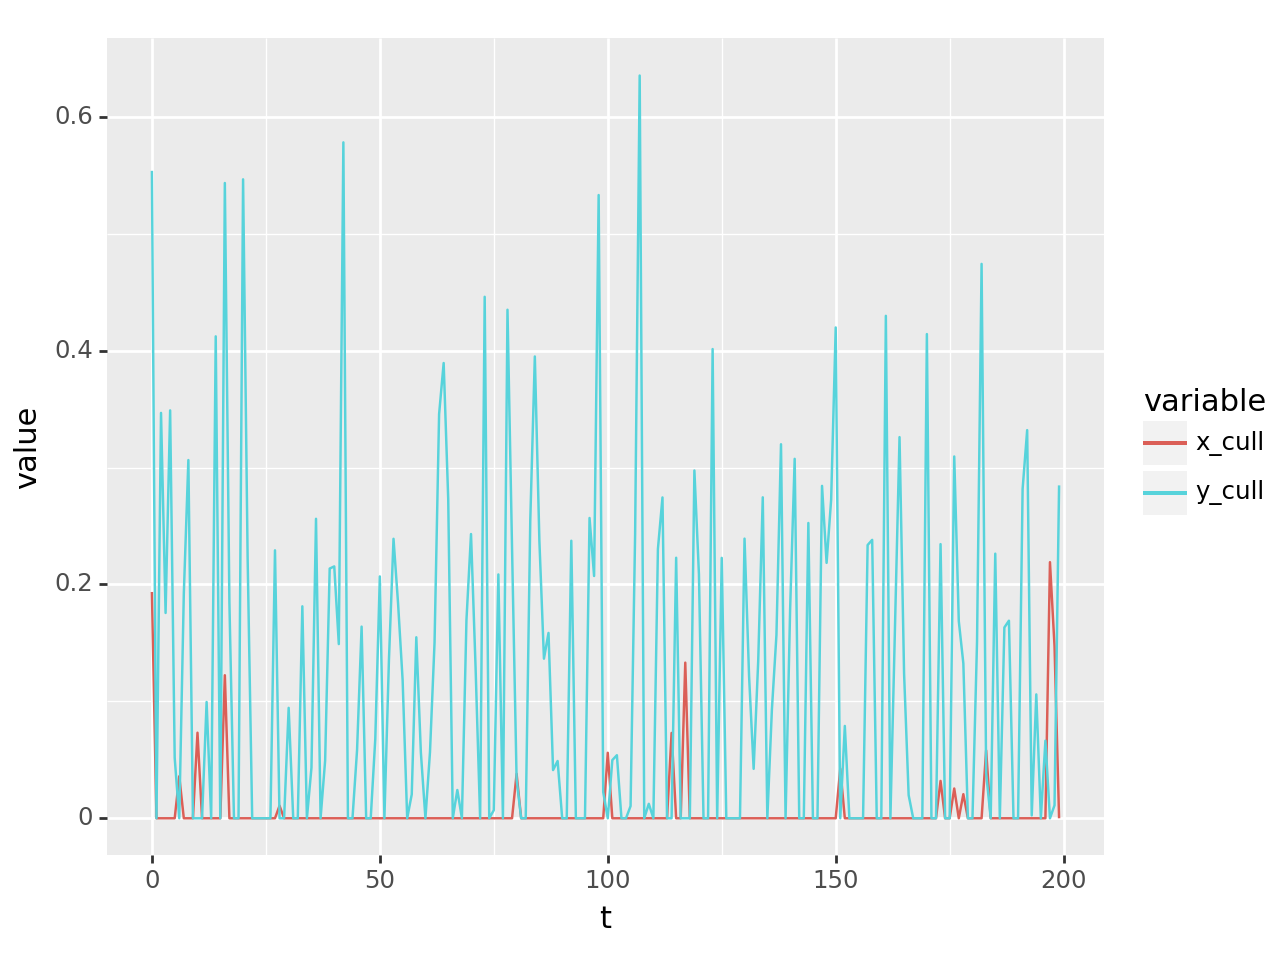

<Figure Size: (640 x 480)>

In [36]:
plot_episode(episode_df[['t', 'x_cull', 'y_cull']])